In [3]:

import torch
from sklearn.svm import SVR
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sb
from sklearn.svm import SVC #imports support vector classifiers from svm module
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import cm
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore") #to remove unwanted warnings
%matplotlib inline

In [4]:
CancerData=pd.read_csv('Cancer_data.csv')
CancerData.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
CancerData.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [6]:
focused_data=CancerData[['radius_mean','texture_mean','diagnosis']]


In [7]:
focused_data.head()

,radius_mean,texture_mean,diagnosis
0,17.99,10.38,M
1,20.57,17.77,M
2,19.69,21.25,M
3,11.42,20.38,M
4,20.29,14.34,M


In [8]:
#Let's encode the diagnosis since it is categorical
label_encoder=LabelEncoder()
focused_data['class']= label_encoder.fit_transform(focused_data['diagnosis'])
#now let's save the mapping
label_encoder_name_map= dict(zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_)))
print(label_encoder_name_map) #So begnign is 0 and malignant is 1


{'B': 0, 'M': 1}


In [9]:
#Now we dont need diagnosis column
focused_data=focused_data.drop(columns=['diagnosis'])
focused_data.head()

,radius_mean,texture_mean,class
0,17.99,10.38,1
1,20.57,17.77,1
2,19.69,21.25,1
3,11.42,20.38,1
4,20.29,14.34,1


<Axes: xlabel='radius_mean', ylabel='texture_mean'>

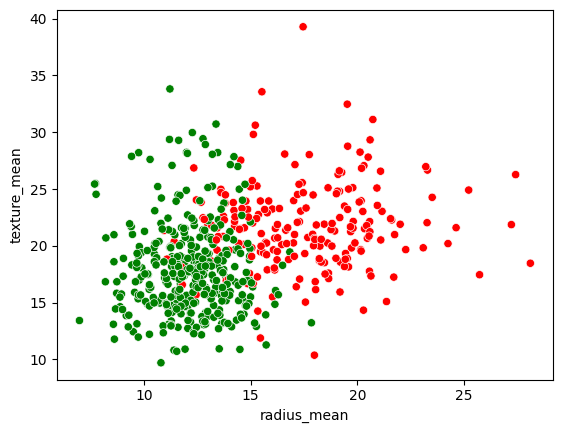

In [10]:
#We want to use SVM

colors = ['green' if diagnosis == 0 else 'red' for diagnosis in focused_data["class"]]
sb.scatterplot(x='radius_mean',y='texture_mean',data=CancerData, c=colors)


In [11]:
focused_data.head()

,radius_mean,texture_mean,class
0,17.99,10.38,1
1,20.57,17.77,1
2,19.69,21.25,1
3,11.42,20.38,1
4,20.29,14.34,1


In [12]:

x=focused_data.drop(columns='class')
y=focused_data['class']

#now we have x,y
#let's now split into train and testing data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=3)
print("train: ",x_train.shape)
print("test: ",x_test.shape)



train:  (426, 2)
test:  (143, 2)


In [13]:
#Now that we have got the x train and test and y train and test we can begin scaling adn stuff
#Normalize first
scaler=StandardScaler()
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x_train.columns) #Why do we need to make it into a dataframe again?
x_test=pd.DataFrame(scaler.fit_transform(x_test),columns=x_test.columns)
x_train.head()

,radius_mean,texture_mean
0,-0.735590,-0.175979
1,-0.915578,0.557735
2,1.601439,0.719975
3,-0.474045,-0.527096
4,-0.625910,0.482668


In [14]:
#Let's work with Support Vector Classifiers of diff kernels

#function to choose the kernel of the SVC, other parameters are default
def getClassifier(ktype):
    if ktype == 0:
        # Linear kernal
        return SVC(kernel='linear')
    elif ktype == 1:
        # Polynomial kernal
        return SVC(kernel='poly')
    elif ktype == 2:
        # Radial Basis Function kernal
        return SVC(kernel='rbf')

In [15]:
kernels = ["Linear","Polynomial","RBF"]
for i in range(len(kernels)):
    svclassifier = getClassifier(i) #get SVC with different kernels
    svclassifier.fit(x_train, y_train)   #fit train data for each kernel
    y_pred = svclassifier.predict(x_test)
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Linear kernel
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        90
           1       0.90      0.81      0.85        53

    accuracy                           0.90       143
   macro avg       0.90      0.88      0.89       143
weighted avg       0.90      0.90      0.89       143

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

           0       0.83      0.99      0.90        90
           1       0.97      0.66      0.79        53

    accuracy                           0.87       143
   macro avg       0.90      0.82      0.85       143
weighted avg       0.88      0.87      0.86       143

Evaluation: RBF kernel
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        90
           1       0.90      0.85      0.87        53

    accuracy                           0.91       143
   macro avg       0.91      0.90      0.90      

In [16]:

param_grid = {'C': [0.1,1, 10], 'gamma': [0.1,0.01],'kernel': ['linear', 'poly','rbf']}

In [17]:
grid=GridSearchCV(SVC(),param_grid,refit=True,verbose=3,scoring='f1')
grid.fit(x_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.921 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.808 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.839 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.852 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.171 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.229 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.171 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.061 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.061 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.951 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 0.01],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='f1', verbose=3)

In [18]:
#Now we can check best params
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [19]:
grid.best_estimator_

SVC(C=10, gamma=0.1)

In [20]:
model=SVC(C=10,gamma=0.1,kernel='rbf')


In [21]:
model.fit(x_train,y_train)
mean_accuracy=model.score(x_test,y_test)
print("Mean accuracy Train Data: ")
mean_accuracy_train=model.score(x_train,y_train)
print(mean_accuracy_train)
print("Mean accuracy test: ")
print(mean_accuracy)

Mean accuracy Train Data: 
0.8990610328638498
Mean accuracy test: 
0.9090909090909091
